# Detailed stats of HGVS in ClinVar

Looking only at records with no functional consequences and no complete `chr_pos_ref_alt` coordinates. Based on June consequence predictions and ClinVar dump.

## Table of contents

1. [Sequence types](#Sequence-types)
2. [Variant types](#Variant-types)
3. [Ranges](#Ranges)
    1. [Span lengths](#Span-lengths)
    2. [Intronic numbering](#Intronic-numbering)
4. [Summary](#Summary)

In [1]:
import os
import re
import sys

import numpy as np

from eva_cttv_pipeline.clinvar_xml_utils import *
from eva_cttv_pipeline.clinvar_identifier_parsing import *

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
PROJECT_ROOT = '/home/april/projects/opentargets/complex-events'

# dump of all records with no functional consequences and no complete coordinates
# uses June consequence pred + ClinVar 6/26/2021
no_consequences_path = os.path.join(PROJECT_ROOT, 'no-conseq_no-coords.xml.gz')
dataset = ClinVarDataset(no_consequences_path)

In [3]:
def count_hgvs(dataset, regex_dict, exclusive=False, limit=None, include_no_hgvs=True, include_none=True):
    """
    Counts records in dataset with HGVS matching a collection of regexes.
    Can be exclusive or non-exclusive counts (see below).
    If limit is provided, will count at most that many records (useful for testing).
    
    Notes:
      * records with multiple HGVS expressions need at least one matching a given regex to be counted once
      * can also count measures with no HGVS and ones that match none of the regexes (only if not exclusive)
      * non-exclusive => record has an HGVS expression that matches this regex.
                         "If we do support X, how many records could we get?"
      * exclusive => record _only_ has HGVS expressions that match this regex (out of this collection).
                     "If we don't support X, how many records must we lose?"
        
    """
    n = 0
    # just use a dict instead of a counter, so we have a predictable key order
    results = {k: 0 for k in regex_dict}
    if include_no_hgvs:
        results['no hgvs'] = 0
    if not exclusive and include_none:
        results['none'] = 0

    for record in dataset:
        if not record.measure:
            continue
        if not record.measure.hgvs:
            if include_no_hgvs:
                results['no hgvs'] += 1
            continue

        hs = [h for h in record.measure.hgvs if h is not None]
        n += 1
        if limit and n > limit:
            break

        temp_results = {
            k: any(r.match(h) for h in hs)
            for k, r in regex_dict.items()
        }
        any_match = False
        for k in regex_dict:
            if exclusive:
                if temp_results[k] and not any(temp_results[j] for j in regex_dict if j != k):
                    results[k] += 1
            else:
                if temp_results[k]:
                    results[k] += 1
                    any_match = True
        if not exclusive and include_none and not any_match:
            results['none'] += 1
            
    return results

In [4]:
def print_example_matches(dataset, regex_dict, size=1, limit=None, include_none=True):
    """
    Like count_hgvs but returns (size) example matches for each regex where possible.
    """
    n = 0
    all_matches = {k: [] for k in regex_dict}
    if include_none:
        all_matches['none'] = []

    for record in dataset:
        if not record.measure or not record.measure.hgvs:
            continue

        hs = [h for h in record.measure.hgvs if h is not None]
        n += 1
        if limit and n > limit:
            break
            
        for h in hs:
            any_match = False
            for k, r in regex_dict.items():
                if r.match(h):
                    all_matches[k].append(h)
                    any_match = True
            if not any_match and include_none:
                all_matches['none'].append(h)

    result = {
        k: [v[i] for i in np.random.choice(len(v), size=min(len(v), size), replace=False)] if v else []
        for k, v in all_matches.items()
    }
    for k in result:
        print(k)
        for s in result[k]:
            print(f'  {s}')
        print('\n==========\n')

# Sequence types

Refer to documentation [here](https://varnomen.hgvs.org/bg-material/refseq/).

[Top of page](#Table-of-contents)

In [7]:
# be more lenient than what we currently in identifier_parsing
# for example this allows things like `chr11` or `LRG_199p1`
sequence_identifier = r'[a-zA-Z0-9_.]+:'

seq_type_dict = {
    'coding': re.compile(sequence_identifier + r'c\.'),
    'genomic': re.compile(sequence_identifier + r'g\.'),
    'non-coding': re.compile(sequence_identifier + r'n\.'),  # transcript but not coding for a protein
    'protein': re.compile(sequence_identifier + r'p\.'),
    'mitochondrial': re.compile(sequence_identifier + r'm\.'),
    'circular': re.compile(sequence_identifier + r'o\.'),
    'RNA': re.compile(sequence_identifier + r'r\.'),
}

In [398]:
print_example_matches(dataset, seq_type_dict, size=5)

coding
  NM_006140.6:c.1056A>T
  NM_007294.3:c.(5074+1_5075-1)_(*1_?)del
  NM_001379164.1:c.586G>A
  NM_001135651.3:c.95A>G
  NM_017730.3:c.1812_1813del


genomic
  NC_000007.14:g.(?_5991963)_(5999285_?)del
  NC_000009.11:g.(?_304561)_(464239_?)del
  NC_000007.13:g.(?_65425884)_(65447170_?)dup
  NC_000023.11:g.(?_139541049)_(139563439_?)del
  NC_000023.10:g.(?_32235023)_(32430336_?)dup


non-coding
  U43746.1:n.6437delT
  NR_027760.3:n.997A>T
  NR_027760.3:n.790C>T
  NR_027760.2:n.609G>A
  NR_110830.1:n.963T>G


protein
  NP_000442.1:p.(=)
  NP_758450.1:p.Arg28Pro
  NP_000393.4:p.Leu91del
  NP_001366094.1:p.Leu183fs
  NP_001155001.1:p.Asp300=


mitochondrial
  NC_012920.1:m.961delTinsC(2_7)
  NC_012920.1:m.961_962delinsC(n)
  NC_012920.1:m.8350_13450del
  NC_012920.1:m.961_962delinsC(n)


circular


RNA
  NM_006867.3:r.1_989::NM_000245.2:r.3216_6641
  NM_001080517.1:r.627_810del
  NM_013318.3:r.1_2107::NM_004304.4:r.3173_4863


none
  c.(1845+1_1846-1)_(2311+1_2312-1)dup
  p.?
  c.(67+

In [399]:
seq_type_counts = count_hgvs(dataset, seq_type_dict, exclusive=False)

<BarContainer object of 9 artists>

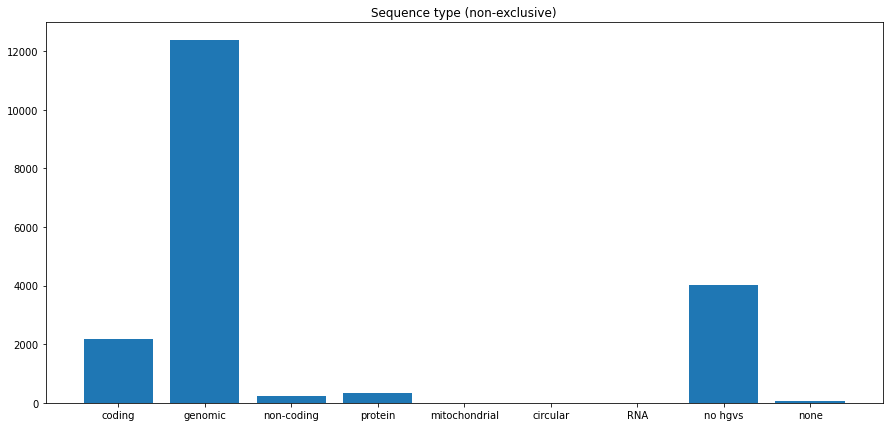

In [400]:
plt.figure(figsize=(15,7))
plt.title('Sequence type (non-exclusive)')
plt.bar(seq_type_counts.keys(), seq_type_counts.values())

In [401]:
seq_type_counts

{'coding': 2192,
 'genomic': 12365,
 'non-coding': 225,
 'protein': 331,
 'mitochondrial': 3,
 'circular': 0,
 'RNA': 3,
 'no hgvs': 4030,
 'none': 60}

In [386]:
# coding or non-coding
2192 + 225

2417

In [370]:
# have hgvs in general
17649 - 4030

13619

In [402]:
seq_type_counts_exclusive = count_hgvs(dataset, seq_type_dict, exclusive=True)

<BarContainer object of 8 artists>

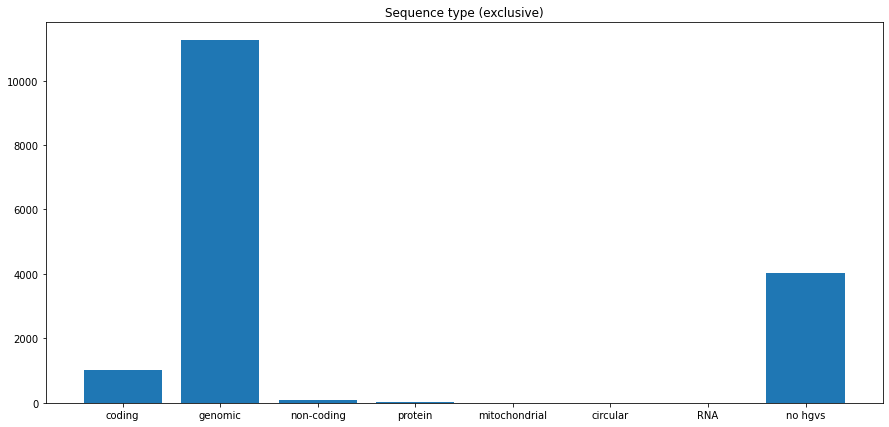

In [403]:
plt.figure(figsize=(15,7))
plt.title('Sequence type (exclusive)')
plt.bar(seq_type_counts_exclusive.keys(), seq_type_counts_exclusive.values())

In [404]:
seq_type_counts_exclusive

{'coding': 1030,
 'genomic': 11248,
 'non-coding': 77,
 'protein': 22,
 'mitochondrial': 3,
 'circular': 0,
 'RNA': 3,
 'no hgvs': 4030}

# Variant types

Documentation [here](https://varnomen.hgvs.org/recommendations/general/)

Compare stats [here](https://github.com/EBIvariation/eva-opentargets/tree/master/data-exploration/clinvar-variant-types#variation-representation) - distribution over all of ClinVar, using XML attribute not HGVS

[Top of page](#Table-of-contents)

In [9]:
genomic_sequence = f'^{sequence_identifier}g\.'
all_other_sequence = f'^{sequence_identifier}[a-fh-z]\.'

In [441]:
# double-counts hybrid things, e.g.
#  * NC_000013.9:g.93703239_93802554del99316insCTA
#  * NC_000016.9:g.2155486_2155487ins2145304_2155487inv
variant_regex = {
    'substitution (genomic)': re.compile(f'{genomic_sequence}.*?>.*?'),
    'deletion (genomic)': re.compile(f'{genomic_sequence}.*?del(?!ins).*?'),
    'duplication (genomic)': re.compile(f'{genomic_sequence}.*?dup.*?'),
    'insertion (genomic)': re.compile(f'{genomic_sequence}.*?(?<!del)ins.*?'),
    'inversion (genomic)': re.compile(f'{genomic_sequence}.*?inv.*?'),
    'delins (genomic)': re.compile(f'{genomic_sequence}.*?delins.*?'),
    
    'substitution (other)': re.compile(f'{all_other_sequence}.*?>.*?'),
    'deletion (other)': re.compile(f'{all_other_sequence}.*?del(?!ins).*?'),
    'duplication (other)': re.compile(f'{all_other_sequence}.*?dup.*?'),
    'insertion (other)': re.compile(f'{all_other_sequence}.*?(?<!del)ins.*?'),
    'inversion (other)': re.compile(f'{all_other_sequence}.*?inv.*?'),
    'delins (other)': re.compile(f'{all_other_sequence}.*?delins.*?'),
}

In [442]:
print_example_matches(dataset, variant_regex, size=5)

substitution (genomic)
  NC_000023.10:g.605412C>A
  NC_000024.9:g.1357443G>A
  NG_012926.1:g.5598G>A
  NC_000024.9:g.1357665C>T
  NC_000023.10:g.1407750G>A


deletion (genomic)
  NC_000023.10:g.(?_32827600)_(32841967_?)del
  NC_000014.8:g.100955624_101366977del
  NC_000009.11:g.(?_130616558)_(130616644_?)del
  NC_000017.10:g.(?_41196353)_(41277500_?)del
  NC_000001.11:g.(?_237756278)_(237832657_?)del


duplication (genomic)
  NC_000017.10:g.(?_8212556)_(8226834_?)dup
  NC_000002.11:g.(?_48030537)_(48030834_?)dup
  NC_000024.9:g.555220dup
  NC_000003.11:g.(?_180379629)_(180379815_?)dup
  NC_000010.9:g.79036437_79286611dup


insertion (genomic)
  NG_009385.2:g.5047_5048insGTT
  NC_000023.10:g.1404731_1404732insT
  NC_000016.10:g.54716967_54716968ins[54716967_55565004;AGCTAACAAGTAATACCTAACAGTTATTCAGC]
  NC_000013.11:g.93997007_94063501del66495insATAAATCACTTAGAGATGT
  NC_000013.10:g.32893302_32893303insAlu


inversion (genomic)
  NC_000016.9:g.1566500_2119769inv
  NC_000009.11:g.71705804_7

In [448]:
variant_counts = count_hgvs(dataset, variant_regex, include_no_hgvs=False, exclusive=False)

<BarContainer object of 13 artists>

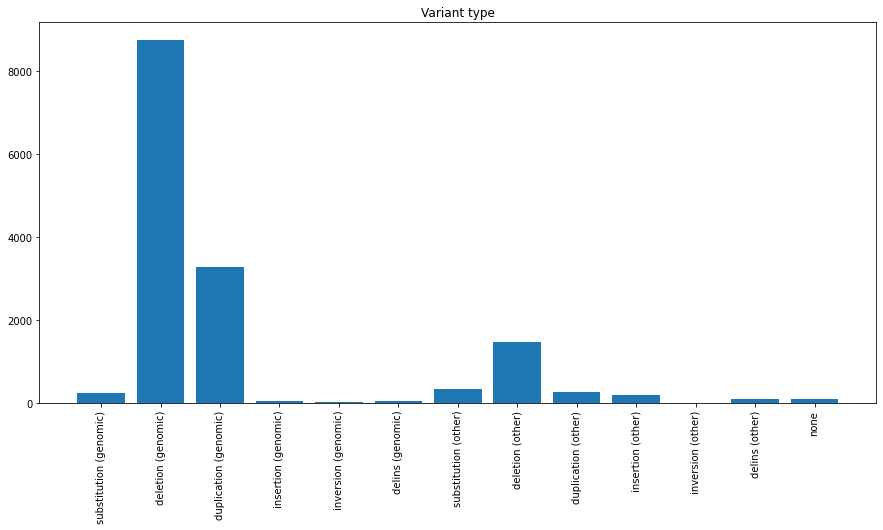

In [449]:
plt.figure(figsize=(15,7))
plt.title('Variant type')
plt.xticks(rotation='vertical')
plt.bar(variant_counts.keys(), variant_counts.values())

In [450]:
variant_counts

{'substitution (genomic)': 245,
 'deletion (genomic)': 8741,
 'duplication (genomic)': 3277,
 'insertion (genomic)': 55,
 'inversion (genomic)': 15,
 'delins (genomic)': 43,
 'substitution (other)': 333,
 'deletion (other)': 1469,
 'duplication (other)': 252,
 'insertion (other)': 187,
 'inversion (other)': 4,
 'delins (other)': 82,
 'none': 95}

# Ranges

Mostly documented [here](https://varnomen.hgvs.org/recommendations/uncertain/) though note the first case is not uncertain.

  * `g.12345_12678del`- no uncertainty
  * `g.(123456_234567)_(345678_456789)del` - variable endpoints within a known range
  * `g.(?_234567)_(345678_?)del` - variable endpoints within an unknown range
  
Also split into genomic vs. other sequences - the former we can definitely deal with, not sure about the others.

See below for intronic coordinate ranges...

[Top of page](#Table-of-contents)

In [10]:
genomic_sequence = f'^{sequence_identifier}g\.'
coding_sequence = f'^{sequence_identifier}c\.'
noncoding_sequence = f'^{sequence_identifier}n\.'
other_sequence = f'^{sequence_identifier}[abdefh-mo-z]\.' # r'^' + sequence_identifier + r'[a-fh-z]\.'
num_range = r'[0-9]+_[0-9]+'
unk_range = r'[0-9?]+_[0-9?]+'
ch = r'[^?_+-]'  # we allow characters on either side of the range, but none of this guff

In [410]:
# g.12345_12678del
def definite_range(sequence_type):
    return re.compile(f'{sequence_type}{ch}*?{num_range}{ch}*?$')


# g.(123456_234567)_(345678_456789)del
def variable_range(sequence_type):
    return re.compile(f'{sequence_type}{ch}*?\({num_range}\)_\({num_range}\){ch}*?$')


# g.(?_234567)_(345678_?)del
def unknown_range(sequence_type):
    return re.compile(f'{sequence_type}{ch}*?(?=.*?\?.*?)\({unk_range}\)_\({unk_range}\){ch}*?$')


range_regex = {
    'definite (genomic)': definite_range(genomic_sequence),
    'variable (genomic)': variable_range(genomic_sequence),
    'unknown (genomic)': unknown_range(genomic_sequence),
    
    'definite (coding)': definite_range(coding_sequence),
    'variable (coding)': variable_range(coding_sequence),
    'unknown (coding)': unknown_range(coding_sequence),
    
    'definite (noncoding)': definite_range(noncoding_sequence),
    'variable (noncoding)': variable_range(noncoding_sequence),
    'unknown (noncoding)': unknown_range(noncoding_sequence),
    
    'definite (other)': definite_range(other_sequence),
    'variable (other)': variable_range(other_sequence),
    'unknown (other)': unknown_range(other_sequence),
}

In [411]:
print_example_matches(dataset, range_regex, size=5)

definite (genomic)
  NG_047171.1:g.53226_78767del
  NC_000017.11:g.43048585_43059975del
  NC_000016.10:g.12595039_12636793del
  NC_000003.12:g.65206172_65228858del
  NC_000002.11:g.160075929_164666149del


variable (genomic)
  NC_000017.11:g.(43063952_43067607)_(43076615_43082403)del
  NC_000011.8:g.(67967534_67967551)_(67974756_67974774)del
  NC_000019.9:g.(11217716_11218068)_(11218190_11219759)del
  NC_000016.10:g.(89767238_89769836)_(89775816_89778800)del
  NC_000016.10:g.(89792548_89795905)_(89803342_89805279)del


unknown (genomic)
  NC_000005.9:g.(?_112162795)_(112179833_?)dup
  NG_009363.1:g.(171122_181389)_(188621_?)del
  NC_000015.10:g.(?_26547773)_(26775295_?)del
  NC_000007.13:g.(?_117227773)_(117227921_?)del
  NC_000020.10:g.(?_10234257)_(10654198_?)del


definite (coding)
  NM_003000.2:c.73_846del
  NM_000249.3:c.1163_1164ins4
  NM_000052.4:c.3152_3156del5ins4
  NM_001379160.1:c.368_377del
  NM_000035.4:c.1_624del


variable (coding)


unknown (coding)
  NM_000260.3:c.(?_6

In [412]:
range_counts = count_hgvs(dataset, range_regex, include_no_hgvs=False)

<BarContainer object of 13 artists>

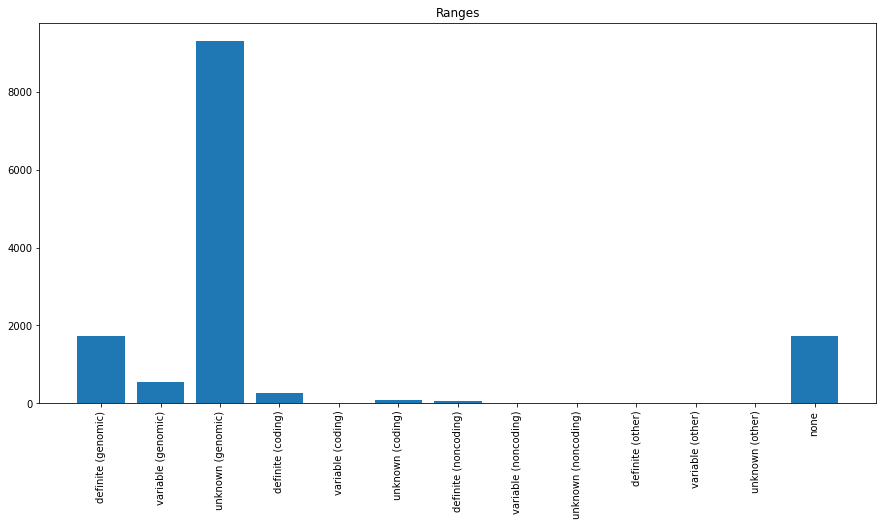

In [413]:
plt.figure(figsize=(15,7))
plt.xticks(rotation='vertical')
plt.title('Ranges')
plt.bar(range_counts.keys(), range_counts.values())

In [414]:
range_counts

{'definite (genomic)': 1735,
 'variable (genomic)': 559,
 'unknown (genomic)': 9311,
 'definite (coding)': 264,
 'variable (coding)': 0,
 'unknown (coding)': 79,
 'definite (noncoding)': 58,
 'variable (noncoding)': 0,
 'unknown (noncoding)': 0,
 'definite (other)': 7,
 'variable (other)': 0,
 'unknown (other)': 0,
 'none': 1739}

In [369]:
# genomic ranges
1735 + 559 + 9311

11605

In [387]:
# coding / noncoding ranges
264 + 79 + 58

401

## Span lengths

Lengths of spans - definite or minimum provided.  For now only compute for genomic sequences, as getting span length for coding/noncoding is a bit more complicated.

[Top of page](#Table-of-contents)

In [5]:
def span_lengths(dataset, regex, limit=None):
    """
    Returns all span lengths for a given regex.
    This will take the first two captured groups of the regex, convert to integers, and subtract the two.
    It will NOT be smart.
    """
    n = 0
    all_spans = []
    
    for record in dataset:
        if not record.measure or not record.measure.hgvs:
            continue

        hs = [h for h in record.measure.hgvs if h is not None]
        n += 1
        if limit and n > limit:
            break
            
        for h in hs:
            m = regex.match(h)
            if m and m.group(1) and m.group(2):
                span = int(m.group(2)) - int(m.group(1)) + 1
                if span < 0:
                    print('negative span!!!', h)
                else:
                    all_spans.append(span)
                # presumably all hgvs expressions for one record have the same span, don't double count
                break
                
    return all_spans

In [11]:
# same as previous but with capturing groups added
def_range = r'([0-9]+)_([0-9]+)'
var_range = r'\([0-9?]+_([0-9]+)\)_\(([0-9]+)_[0-9?]+\)'
def_span_regex = re.compile(f'{genomic_sequence}{ch}*?{def_range}{ch}*?$')
var_span_regex = re.compile(f'{genomic_sequence}{ch}*?{var_range}{ch}*?$')

In [12]:
spans = span_lengths(dataset, def_span_regex) + span_lengths(dataset, var_span_regex)

negative span!!! NC_000016.9:g.(?_14725823)_(14643928_?)del
negative span!!! NC_000003.11:g.(128203154_128202733)_(128202028_128201205)del
negative span!!! NC_000002.11:g.(?_86565200)_(86481816_86479194)del
negative span!!! NC_000015.9:g.(?_44955845)_(44918529_44914997)del
negative span!!! NC_000015.9:g.(44887456_44884637)_(44881449_44878049)del
negative span!!! NC_000015.9:g.(44884528_44881613)_(44877833_44876757)dup


In [348]:
# This is everything with a known minimum span - genomic reference sequence, X_Y or (?_X)_(Y_?)
print(len(spans))

11529


In [350]:
print('Mean:', np.mean(spans))
print('Median:', np.median(spans))
print('Min:', np.min(spans))
print('Max:', np.max(spans))

Mean: 382710.48798681586
Median: 19283.0
Min: 2
Max: 200036731


In [453]:
# actually reasonable spans...
MAX_REASONABLE_SPAN = 20000 #100000

smaller_spans = [x for x in spans if x < MAX_REASONABLE_SPAN]
print(len(smaller_spans))

5827


(array([1419.,  479.,  137.,  124.,  103.,  113.,   84.,  107.,  118.,
          79.,   84.,   88.,   73.,   67.,   55.,   71.,   66.,   63.,
          81.,   47.,   56.,   63.,   50.,   53.,   58.,   39.,   46.,
          63.,   40.,   35.,   37.,   57.,   52.,   29.,   41.,   40.,
          45.,   24.,   34.,   41.,   36.,   46.,   33.,   22.,   26.,
          32.,   29.,   32.,   29.,   26.,   29.,   22.,   29.,   37.,
          28.,   32.,   23.,   37.,   31.,   27.,   22.,   33.,   28.,
          19.,   14.,   21.,   37.,   25.,   23.,   17.,   21.,   28.,
          23.,   24.,   22.,   28.,   25.,   18.,   24.,   26.,   24.,
          20.,   24.,   16.,   23.,   34.,   23.,   15.,   10.,   16.,
          20.,   13.,   19.,   16.,   12.,   23.,   19.,   19.,   17.,
          19.]),
 array([2.000000e+00, 2.019500e+02, 4.019000e+02, 6.018500e+02,
        8.018000e+02, 1.001750e+03, 1.201700e+03, 1.401650e+03,
        1.601600e+03, 1.801550e+03, 2.001500e+03, 2.201450e+03,
        2.

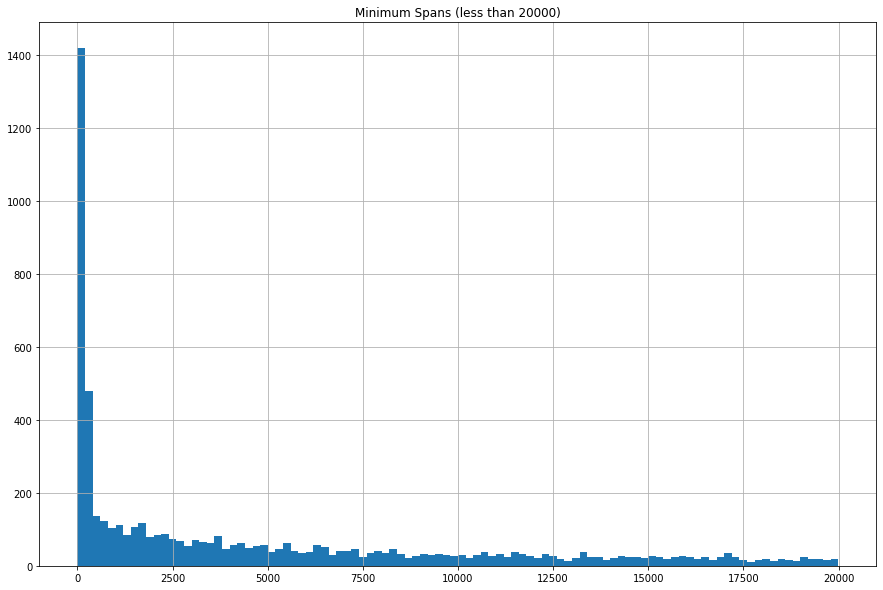

In [454]:
plt.figure(figsize=(15,10))
plt.grid(visible=True)
plt.title(f'Minimum Spans (less than {MAX_REASONABLE_SPAN})')
# first array is counts per bin
# second array is left edges of bins, plus last right edge
plt.hist(smaller_spans, bins=100)

In [13]:
# VEP acceptable spans
vep_spans = [x for x in spans if x < 5000]
print(len(vep_spans))

3738


## Intronic numbering

Documentation [here](https://varnomen.hgvs.org/bg-material/numbering/) and particularly the [diagram](https://varnomen.hgvs.org/assets/RefSeq.jpg).

Only used for coding and non-coding reference sequences, so not relevant if we focus on genomic.

[Top of page](#Table-of-contents)

In [432]:
coding_sequence = r'^' + sequence_identifier + r'c\.'
other_sequence = r'^' + sequence_identifier + r'[abd-z]\.'

pivot = r'[-*]?[0-9]+'
offset = r'[+-][0-9]+'
endpoint = pivot + offset

num_range = f'{endpoint}_{endpoint}'
unk_range = f'(?:{endpoint}|\?)_(?:{endpoint}|\?)'
ch = r'[^?_+-]'  # we allow characters on either side of the range, but none of this guff

irange_regex = {
    'definite intron (coding)': re.compile(coding_sequence + f'{ch}*?{num_range}{ch}*?$'),
    'variable intron (coding)': re.compile(coding_sequence + f'{ch}*?\({num_range}\)_\({num_range}\){ch}*?$'),
    'unknown intron (coding)': re.compile(coding_sequence + f'{ch}*?(?=.*?\?.*?)\({unk_range}\)_\({unk_range}\){ch}*?$'),
    'definite intron (other)': re.compile(other_sequence + f'{ch}*?{num_range}{ch}*?$'),
    'variable intron (other)': re.compile(other_sequence + f'{ch}*?\({num_range}\)_\({num_range}\){ch}*?$'),
    'unknown intron (other)': re.compile(other_sequence + f'{ch}*?(?=.*?\?.*?)\({unk_range}\)_\({unk_range}\){ch}*?$'),
}

In [452]:
print_example_matches(dataset, irange_regex, size=5, include_none=False)

definite intron (coding)
  LRG_214t1:c.889-1633_7395-667del
  NM_000135.2:c.1006+727_1626+1288del
  NM_000267.3:c.7000-499_7908-479del
  NM_000267.3:c.655-60_888+5621delins135
  NM_001379166.1:c.473+16_473+17del


variable intron (coding)
  LRG_274t1:c.(67+1_68-1)_(1586+1_1587-1)del
  LRG_627t2:c.(3502+1_3503-1)_(4173+1_4174-1)del
  NM_000135.2:c.(2601+1_2602-1)_(2981+1_2982-1)del
  NM_000492.3:c.(1766+1_1767-1)_(2619+1_2620-1)del
  LRG_274t1:c.(940+1_941-1)_(1186+1_1187-1)del


unknown intron (coding)
  NM_000535.5:c.(?_989-5)_(2445+5_?)del
  LRG_199t1:c.(?_6439-24498)_(7873-5329_?)del
  NM_172095.1:c.(?_718-34)_(843-857_?)del
  NM_001142800.1:c.(2259+1_2260-1)_(2381+1_?)del
  LRG_161t1:c.(?_989-5)_(2445+5_?)del


definite intron (other)
  U43746.1:n.7830-114_7830-112delAGT
  U43746.1:n.9877-68_9877-65delTTAC
  U14680.1:n.5396+47_5396+48ins20


variable intron (other)


unknown intron (other)




<BarContainer object of 6 artists>

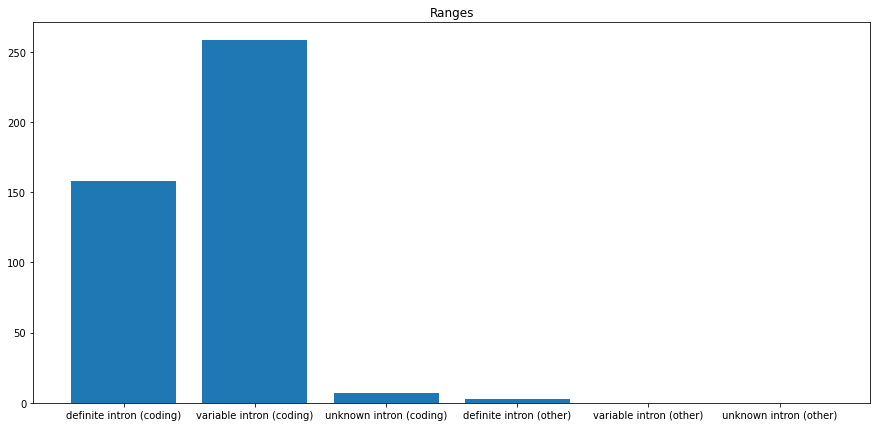

In [434]:
irange_counts = count_hgvs(dataset, irange_regex, include_no_hgvs=False, include_none=False)

plt.figure(figsize=(15,7))
plt.title('Ranges')
plt.bar(irange_counts.keys(), irange_counts.values())

In [435]:
irange_counts

{'definite intron (coding)': 158,
 'variable intron (coding)': 258,
 'unknown intron (coding)': 7,
 'definite intron (other)': 3,
 'variable intron (other)': 0,
 'unknown intron (other)': 0}

In [436]:
sum(irange_counts.values())

426

# Summary

* **17,649** records without consequences and without complete coordinates
    * Of these, **13,619** have HGVS identifiers
        * Of these, **12,365** are genomic
            * Of these, **11,605** involve ranges
                * Of these, **11,529** have a known minimum span
                    * Of these, **5,827** have span less than 20kb
                    
[Top of page](#Table-of-contents)

## Questions / comments

* Can we handle non-genomic reference (in particular coding and non-coding, possibly also protein - direct to consequence not via coordinates)?
* Still some substitutions, can we pick those up?
    * if ClinVar didn't create coordinates, is there a reason why?
* What things aren't included in these range expressions? (see below)
    * point deletions `NC_000023.10:g.32459297del`
    * point insertions `NM_000179.2:c.3557-4insT`
    * substitutions `LRG_199t1:c.357+1G>A`
    * protein substitutions `NP_758448.1:p.Gly177Glu`
    * "advanced" stuff like translocations - see [here](https://varnomen.hgvs.org/recommendations/DNA/variant/complex/) (I actually didn't see any of these)
    * miscellaneous errors and things I don't understand `NC_000019.9:g.(?_47255735_47259271del`
    * ...